# CSCI E-109 Milestone 4

**Project Title:**  
“Flight Delay Analysis and Prediction”

**Group Members:**  
Alvaro Ramirez  
James Nicholson  
Xue Jiang  
Christopher Moon


## Notebook Setup

### About the Colab Development Environment

This notebook was built in Google Colab. The Colab version can be found here:
https://colab.research.google.com/drive/1KkbNA_WI_oy_yN9A1zo_fw9-D7lAlMQx?usp=sharing

This is a shared notebook, but we each have our own session (virtual machine). Any files you upload are only available to you, so we each need to upload the data file to our own sessions. Instructions for uploading the file to your session are below.

**From the Google Colab docs**  
"Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if a user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours."

If your session gets terminated for either of the above reasons, your notebook state/cell output/uploaded data will be gone and you'll need to upload the data again.

In [20]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from google.colab import files
from google.colab import drive

import io
import time

### Loading the Data

There are two ways to load the data. You can select the file from your Google Drive (manual access), or you could ask the program to automatically take it from your /data folder in your Google Drive (auto).

Uncomment the variable access with the corresponding value (manual or auto) according to your preference.

- To use manual access, upload the file using the "Choose Files" button that appears when you run the below cell.

- To use the auto access, create a folder called 'data' in your Google Drive and store there the file `Airline_Delay_Cause.csv`.
  

*NOTE: Our data file is about 60MB. The loading process may take a few seconds using the `auto` option or several minutes using the `manual` option.*

In [30]:
# Data source access
# access = 'manual'
access = 'auto'

# Start timer
start_time = time.time()

# Select the file from your Google Drive
if access == 'manual':
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

  df = pd.read_csv(io.BytesIO(uploaded['Airline_Delay_Cause.csv']))

else:
  drive.mount('/content/gdrive')

  # Get the path to the CSV file in Google Drive
  file_path = '/content/gdrive/My Drive/data/Airline_Delay_Cause.csv'

  # Read the CSV file into a Pandas dataframe
  df = pd.read_csv(file_path)

# Print total execution time loading data
print(f'Time loading data: {(time.time() - start_time):.2f} seconds')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Time loading data: 2.69 seconds


## Problem Statement
What would be the predicted number of flight delays for a given airport, airline, and month in a year? To answer the question, first, we need to set `arr_del15`, number of flights delayed more than 15 minutes, as our response variable.

## Exploratory Data Analysis

### Exploring the Data

#### Brief Description

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Our data set consists of summary information on the number of on-time, delayed, canceled and diverted flights during the period of 2003 to 2023.

#### Column Definitions

- **year**: Year data collected
- **month**: Numeric representation of the month
- **carrier**: Carrier code
- **carrier_name**: Carrier Name
- **airport**: Airport code
- **airport_name**: Name of airport
- **arr_flights**: Number of flights arriving at the airport
- **arr_del15**: Number of flights more than 15 minutes late
- **carrier_ct**: Number of flights delayed due to air carrier. (e.g., no crew)
- **weather_ct**: Number of flights due to weather
- **nas_ct**: Number of flights delayed due to National Aviation System (e.g., heavy air traffic)
- **security_ct**: Number of flights canceled due to a security breach
- **late_aircraft_ct**: Number of flights delayed as a result of another flight on the same aircraft delayed
- **arr_cancelled**: Number of canceled flights
- **arr_diverted**: Number of flights that were diverted
- **arr_delay**: Total time (minutes) of delayed flight
- **carrier_delay**: Total time (minutes) of delay due to air carrier
- **weather_delay**: Total time (minutes) of delay due to inclement weather
- **nas_delay**: Total time (minutes) of delay due to National Aviation System
- **security_delay**: Total time (minutes) of delay due to a security issue
- **late_aircraft_delay**: Total time (minutes) of delayed flights due to a previous flight on the same airplane being late

More information can be found at `https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr`

#### First Five Rows

In [ ]:
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


#### Data Shape

In [ ]:
print('Number of columns:', df.shape[1])
print('Number of rows:', df.shape[0])

Number of columns: 21
Number of rows: 345323


#### Data Types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345323 entries, 0 to 345322
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 345323 non-null  int64  
 1   month                345323 non-null  int64  
 2   carrier              345323 non-null  object 
 3   carrier_name         345323 non-null  object 
 4   airport              345323 non-null  object 
 5   airport_name         345323 non-null  object 
 6   arr_flights          344814 non-null  float64
 7   arr_del15            344576 non-null  float64
 8   carrier_ct           344814 non-null  float64
 9   weather_ct           344814 non-null  float64
 10  nas_ct               344814 non-null  float64
 11  security_ct          344814 non-null  float64
 12  late_aircraft_ct     344814 non-null  float64
 13  arr_cancelled        344814 non-null  float64
 14  arr_diverted         344814 non-null  float64
 15  arr_delay        

#### Descriptive Statistics

In [ ]:
pd.DataFrame.describe(df)

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,345323.000000,345323.000000,344814.000000,344576.000000,344814.000000,344814.000000,344814.000000,344814.000000,344814.000000,344814.000000,344814.000000,344814.00000,344814.000000,344814.000000,344814.000000,344814.000000,344814.000000
mean,2013.206213,6.493312,378.935876,73.002383,21.416112,2.633833,23.581905,0.181689,25.138513,7.209551,0.871139,4284.51640,1333.480314,226.415702,1085.411239,7.456852,1631.750196
std,6.042778,3.431955,1021.719103,199.130487,48.984100,9.906200,83.265625,0.853906,76.050857,36.774197,3.917271,12808.59125,3744.297067,875.811434,4538.254555,40.302272,5108.665467
min,2003.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-19.000000,0.000000,0.000000
25%,2008.000000,4.000000,58.000000,9.000000,3.000000,0.000000,1.600000,0.000000,1.650000,0.000000,0.000000,436.00000,148.000000,0.000000,54.000000,0.000000,80.000000
50%,2013.000000,7.000000,120.000000,22.000000,8.150000,0.600000,5.350000,0.000000,5.850000,1.000000,0.000000,1204.00000,439.000000,26.000000,199.000000,0.000000,354.000000
75%,2019.000000,9.000000,270.000000,56.000000,19.760000,2.010000,15.070000,0.000000,17.050000,4.000000,1.000000,3102.00000,1118.000000,162.000000,595.000000,0.000000,1124.000000
max,2023.000000,12.000000,21977.000000,6377.000000,1792.070000,717.940000,4091.270000,80.560000,2069.070000,4951.000000,256.000000,438783.00000,196944.000000,57707.000000,238440.000000,3760.000000,227959.000000


#### Data Missingness

In [ ]:
print(f'Rows with missing values: {df.isnull().any(axis=1).sum()}\n')

print(f'Missing values in each column:\n{df.isnull().sum()}\n')

Rows with missing values: 747

Missing values in each column:
year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            509
arr_del15              747
carrier_ct             509
weather_ct             509
nas_ct                 509
security_ct            509
late_aircraft_ct       509
arr_cancelled          509
arr_diverted           509
arr_delay              509
carrier_delay          509
weather_delay          509
nas_delay              509
security_delay         509
late_aircraft_delay    509
dtype: int64



### Analyzing the Data

#### Missing Values
The series below shows the ratio of rows with missing values to total rows, grouped by carrier. Carriers where the ratio is NaN have no missing rows. This series demonstrates that the rows missing one or more values belonging to any single carrier do not exceed more than 1% of their total row count. Based on this conclusion, we feel comfortable dropping rows with missing values in the preprocessing stage.

In [ ]:
# Rows with missing values.
df_missing = df[df.isnull().any(axis=1)]

# Carrier missing count (series).
cmc = df_missing['carrier'].value_counts()

# Carrier row count (series).
crc = df['carrier'].value_counts()

# Ratio of missing rows to total rows by carrier (series).
rmrtr = cmc / crc

display(rmrtr)

9E    0.003844
AA    0.000509
AQ         NaN
AS    0.000141
B6    0.000636
CO    0.001301
DH    0.000520
DL    0.002189
EV    0.003843
F9    0.002358
FL    0.000144
G4    0.007609
HA    0.000258
HP    0.001265
MQ    0.001172
NK    0.001916
NW    0.001979
OH    0.006946
OO    0.002561
QX         NaN
RU    0.000484
TZ    0.006494
UA    0.001683
US    0.000561
VX    0.002101
WN         NaN
XE    0.001220
YV    0.003049
YX    0.004365
Name: carrier, dtype: float64

#### Imbalanced Independent Variable (Carrier)
We see below that the range of number of rows per airline is large. However while the dataset is imbalanced relatively speaking, in absolute terms most airlines have over 1,000 observations which should be enough to influence the model. We will use dummy binary variables to encode these 29 categories.

In [ ]:
print(f'Number of airlines: {df["carrier"].nunique()}\n')

print(f'Number of rows per airline:\n{df["carrier"].value_counts()}\n')

Number of airlines: 29

Number of rows per airline:
OO    42164
DL    29690
MQ    27295
EV    26799
AA    21591
UA    20794
WN    19181
YV    15417
AS    14220
9E    14047
OH    13965
F9    13568
B6    12573
US    10698
G4     8280
NW     8084
XE     7375
FL     6956
CO     6917
YX     5727
NK     4698
RU     4136
HA     3881
DH     1924
HP     1581
VX     1428
QX     1157
TZ      924
AQ      253
Name: carrier, dtype: int64



#### Independent Categorical Variable With High Cardinality (Airport)
There are 420 airports in our dataset, which is too many for one-hot encoding. The resulting features would be too sparse. After doing some research on the subject, there doesn't appear to be a straightforward way to solve this problem. One method that strikes an OK balance between ease of implimentation and minimal loss of information is to one-hot encode the top 20 airports and then have an additional binary "other" variable for the rest.

In [ ]:
print(f'Number of airports: {df["airport"].nunique()}\n')

print(f'Number of rows per airport:\n{df["airport"].value_counts()}\n')

Number of airports: 420

Number of rows per airport:
DTW    3243
MCI    3202
PIT    3193
RDU    3159
ATL    3155
       ... 
TKI       1
FNL       1
YNG       1
SKA       1
CBM       1
Name: airport, Length: 420, dtype: int64



#### Means of Numerical Columns
Carriers with a higher number of flights (arr_flights) tend to have higher means across count variables. This may merrit looking at delay ratios such as `arr_del15` / `arr_flights` to get a more levelled comparison across airlines of different sizes.

In [ ]:
numeric_columns = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct',
                   'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
                   'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

# Group by 'carrier' and calculate mean
df_mean = df.groupby('carrier')[numeric_columns].mean()

# Print the resulting DataFrame
df_mean

,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
carrier,,,,,,,,,,,,,,,
9E,191.817695,30.056671,8.667412,1.115864,10.771883,0.029472,9.424918,4.628184,0.440314,1974.100678,647.826115,128.750054,506.502390,1.277845,689.744274
AA,654.647751,134.189388,39.604472,6.058700,45.854590,0.300064,42.328038,13.353963,1.845509,8469.652708,2748.228332,488.420577,2072.132117,14.059295,3146.812387
AQ,353.940711,25.193676,12.877391,0.160316,2.296364,0.211304,9.648419,4.644269,0.142292,1037.237154,572.814229,9.079051,62.976285,7.395257,384.972332
AS,249.036711,42.746870,11.911159,0.840955,16.018437,0.336723,13.636652,3.216471,0.680357,2115.519094,688.945073,63.503341,564.011956,12.061045,786.997679
B6,348.160461,84.591484,26.222087,1.393151,28.410203,0.310236,28.222196,6.611774,1.047653,5702.073270,1812.056404,156.916547,1502.785044,13.817422,2216.497852
CO,354.199450,77.772438,16.310093,2.632511,41.464287,0.534284,16.820158,2.951947,1.005790,4342.163265,938.030250,204.725431,2033.298162,17.799826,1148.309596
DH,296.767031,61.310972,13.562054,2.129048,21.608294,0.118274,23.893323,8.400936,0.502860,3657.647426,711.402496,182.768071,1104.009360,3.768591,1655.698908
DL,502.232799,80.581333,24.870479,2.605498,31.412381,0.073439,21.592334,5.869074,0.987818,4749.025915,1763.922220,252.288476,1346.678455,4.711726,1381.407862
EV,243.123198,54.615411,16.971304,2.746812,16.938992,0.041923,17.881700,7.186351,0.645865,3534.326433,1239.646614,222.127279,870.276270,1.986336,1200.289934


### Visualizing the Data

#### Correlation Matrix

The following clustering plot (also known as a dendrogram) creates a hierarchical clustering of the correlation matrix. In this plot, each cell corresponds to the correlation between two of the selected columns in the DataFrame. The color of the cell indicates the strength and direction of the correlation.

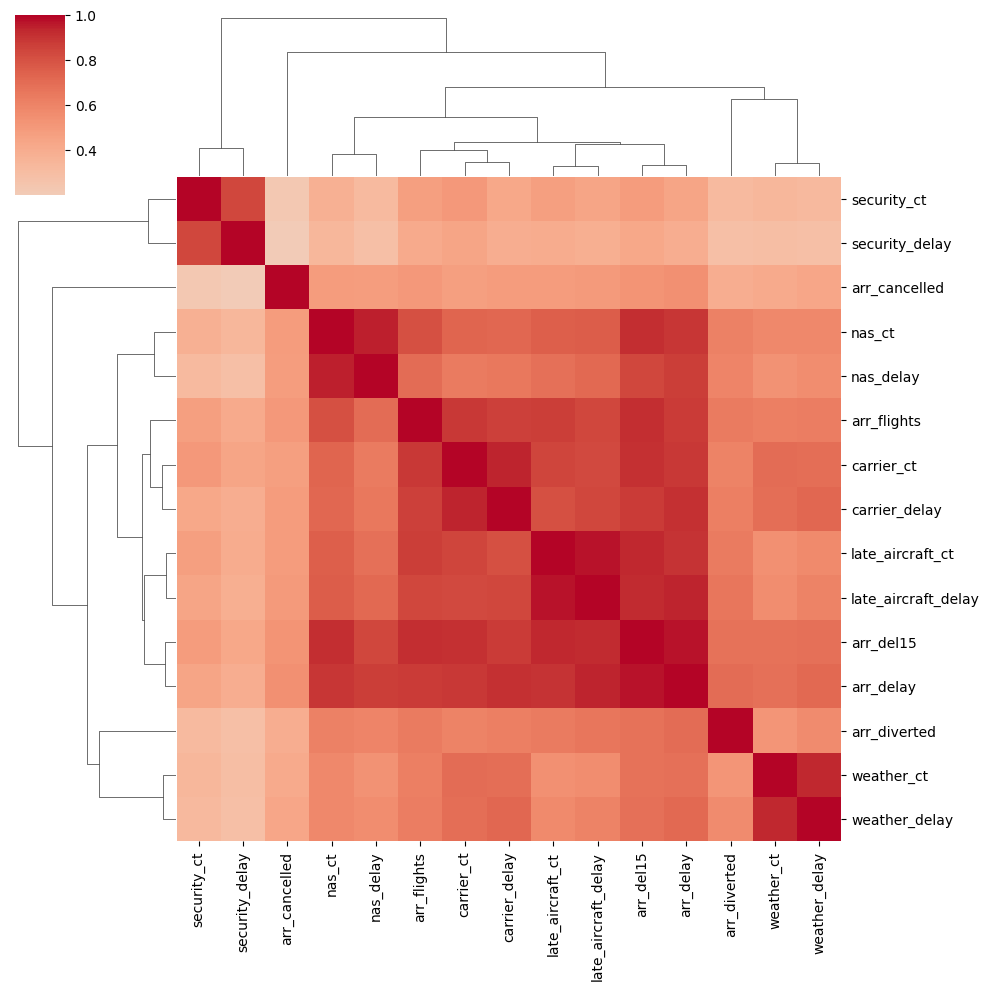

In [ ]:
# Select these columns
df_selected = df[numeric_columns]

# Calculate correlation matrix
corr = df_selected.corr()

# Create a clustering plot
sn.clustermap(corr, cmap='coolwarm', center=0)

plt.show()

In [ ]:
# A helper function to set the size of a plot.
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

#### Number of Observations in the Data Set Grouped by Carrier.

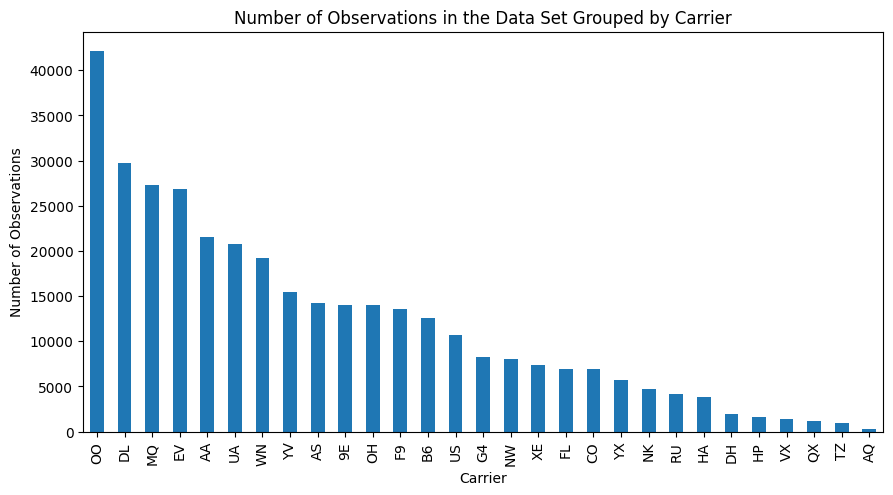

In [ ]:
carr_vc = df['carrier'].value_counts()
fig, ax = plt.subplots()
set_size(8,4, ax=ax)
carr_vc.plot(kind='bar', ax=ax)
plt.title('Number of Observations in the Data Set Grouped by Carrier', fontsize=12)
plt.xlabel('Carrier')
plt.ylabel('Number of Observations')
plt.show()

#### Count of Records in the Dataset Grouped by Airport.

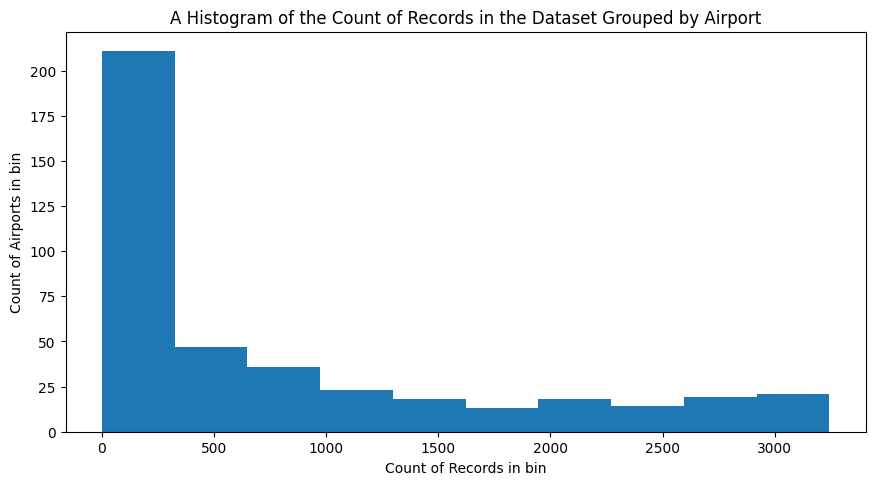

In [ ]:
airport_vc = df['airport'].value_counts()
fig, ax = plt.subplots()
set_size(8,4, ax=ax)
ax.hist(airport_vc)
plt.title('A Histogram of the Count of Records in the Dataset Grouped by Airport', fontsize=12)
plt.xlabel('Count of Records in bin')
plt.ylabel('Count of Airports in bin')
plt.show()

#### Average Weather Delay by Month

The following graph shows that delays increase during high-traffic periods (summer and end-of-year holiday season).

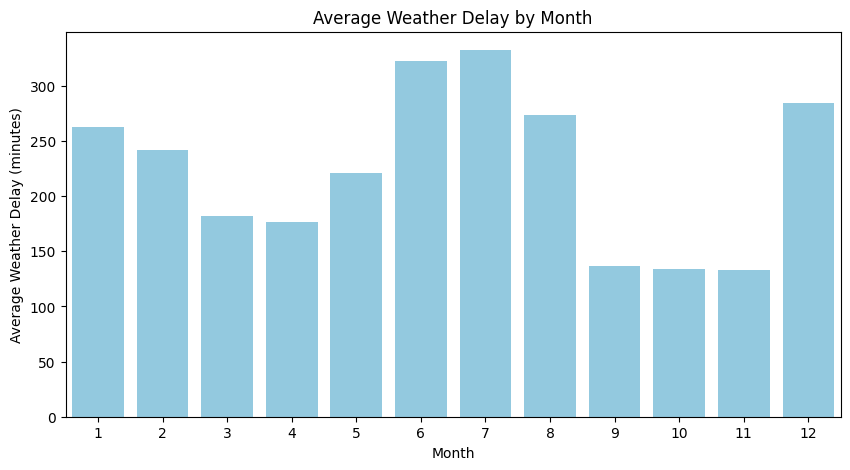

In [10]:
monthly_weather_delay = df.groupby('month')['weather_delay'].mean()

correlation, _ = pearsonr(monthly_weather_delay.index, monthly_weather_delay.values)

plt.figure(figsize=(10, 5))
sn.barplot(x=monthly_weather_delay.index, y=monthly_weather_delay.values, color='skyblue')

plt.title("Average Weather Delay by Month")
plt.xlabel("Month")
plt.ylabel("Average Weather Delay (minutes)")
plt.show()

#### Heatmap of Delays by Carrier and Month

As expected, there seem to be more delays in the summer and winter months, where there is more extreme weather as well as vacation time. It also highlights those airlines with more delays.

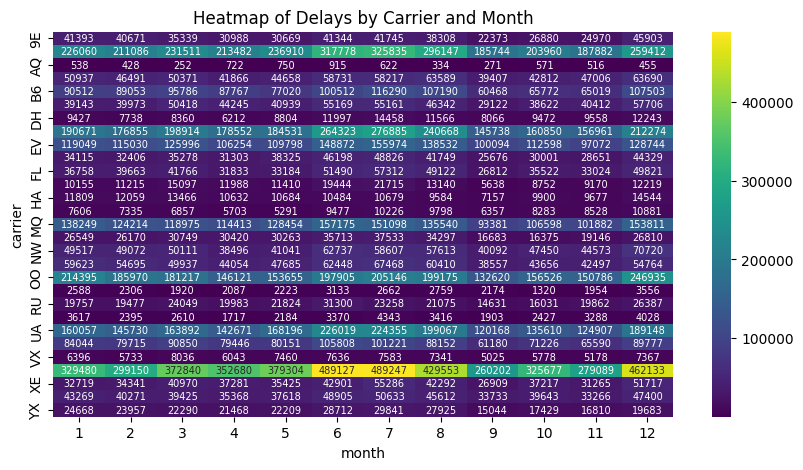

In [18]:
carrier_month_delay = df.pivot_table(values='arr_del15', index='carrier', columns='month', aggfunc='sum')
plt.figure(figsize=(10, 5))

# Set font size for heatmap labels and values
sn.heatmap(carrier_month_delay, annot=True, fmt=".0f", cmap='viridis', annot_kws={'fontsize': 7})

# Set font size for heatmap title
plt.title('Heatmap of Delays by Carrier and Month', fontsize=12)
plt.show()

#### Average Delay Length vs. Month

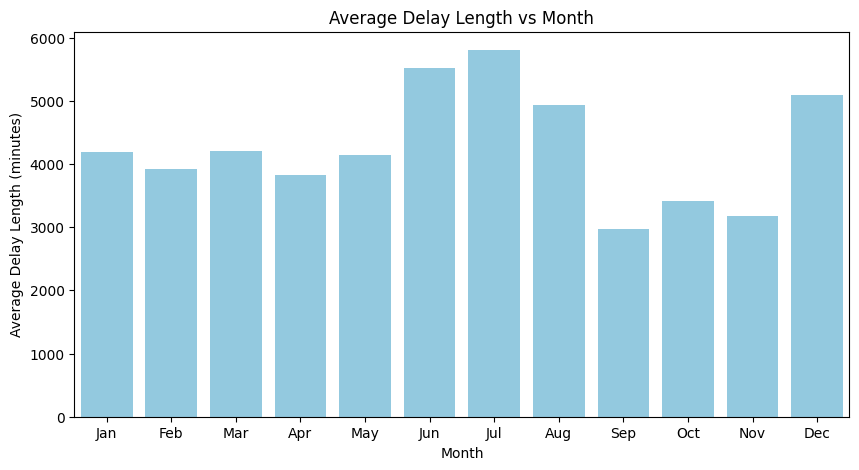

In [12]:
monthly_average_delays = df.groupby('month')['arr_delay'].mean().reset_index()

plt.figure(figsize=(10, 5))
sn.barplot(x='month', y='arr_delay', data=monthly_average_delays, color='skyblue')

plt.title('Average Delay Length vs Month')
plt.xlabel('Month')
plt.ylabel('Average Delay Length (minutes)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### Monthly Trends for Specific Delay Causes

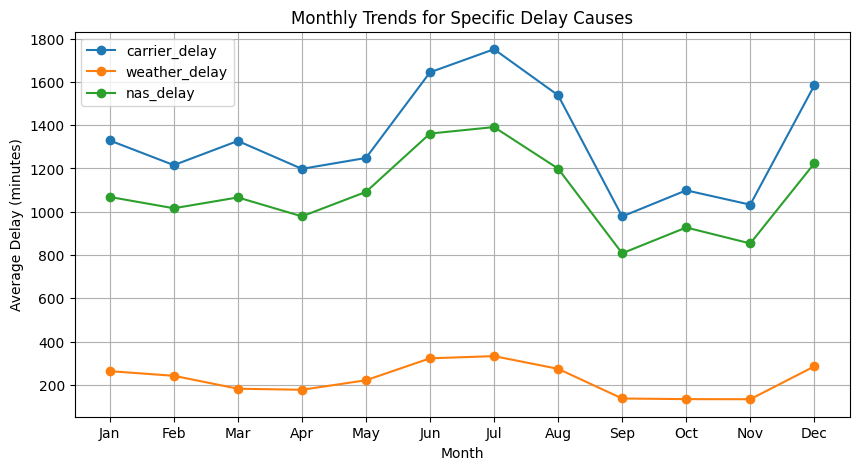

In [13]:
monthly_delay_causes = df.groupby('month')[['carrier_delay', 'weather_delay', 'nas_delay']].mean().reset_index()

plt.figure(figsize=(10, 5))
for cause in ['carrier_delay', 'weather_delay', 'nas_delay']:
    plt.plot(monthly_delay_causes['month'], monthly_delay_causes[cause], marker='o', label=cause)
plt.title('Monthly Trends for Specific Delay Causes')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


#### Top 10 Airports by Average Delay Ratio for Carrier AA

<ipython-input-25-dcd32faa858e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_data['delay_ratio'] = aa_data['arr_del15'] / aa_data['arr_flights']


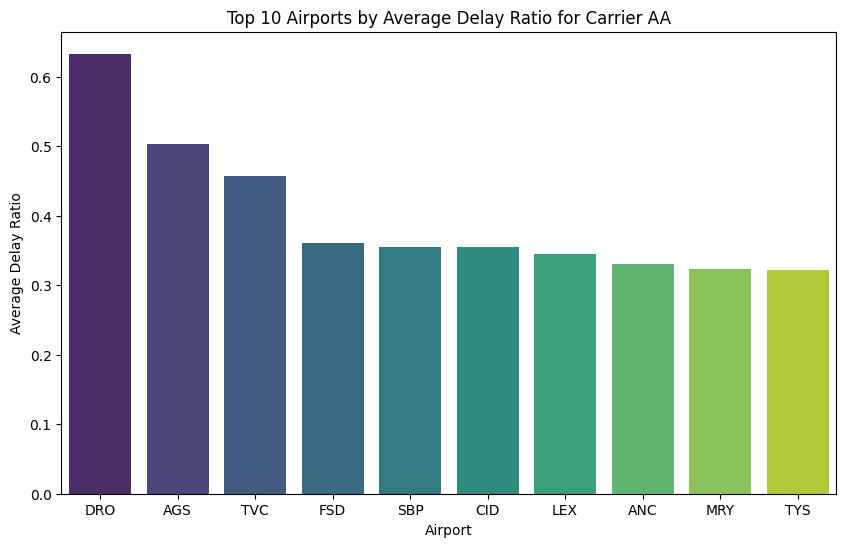

In [ ]:
aa_data = df_multi_year[df_multi_year['carrier'] == 'AA']

aa_data['delay_ratio'] = aa_data['arr_del15'] / aa_data['arr_flights']

airport_delay_ratio = aa_data.groupby('airport')['delay_ratio'].mean().reset_index()

airport_delay_ratio_sorted = airport_delay_ratio.sort_values('delay_ratio', ascending=False)

aa_df_top10 = airport_delay_ratio_sorted.head(10)

plt.figure(figsize=(10, 6))
sn.barplot(x='airport', y='delay_ratio', data=aa_df_top10, color='skyblue')
plt.title('Top 10 Airports by Average Delay Ratio for Carrier AA')
plt.xlabel('Airport')
plt.ylabel('Average Delay Ratio')
plt.show()


## Data Preprocessing

### Data Cleaning

####Duplicate records

The following code looks for rows with the same combination year, month, carrier, airport.

In [26]:
# Identify duplicate records based on 'year', 'month', 'carrier', and 'airport'
duplicate_rows = df.loc[df.duplicated(subset=['year', 'month', 'carrier', 'airport'])]

# Check if any duplicate records were found
if not duplicate_rows.empty:
    print("Duplicate records found:")
    print(duplicate_rows)
else:
    print("No duplicate records found")

No duplicate records found


####Rows with no numerical values

Another case to be analyzed is when rows do not show numerical values (year and month not included). Section **Exploratory Data Analysis / Exploring the Data / Data Missingness** allowed us to detect 509 records with no numerical data. A detailed analysis showed that it happens when airlines have no trips during a specific period (month/year) for a specific airport:

`arr_flights = NaN`

Under these conditions, those records provide no useful information and can be removed.

In [31]:
# Remove records with NaN values in 'arr_flights'
df_clean = df.dropna(subset=['arr_flights'])
df_clean

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345318,2003,6,DL,Delta Air Lines Inc.,SEA,"Seattle, WA: Seattle/Tacoma International",480.0,84.0,25.69,3.09,...,0.0,21.26,0.0,0.0,3744.0,978.0,164.0,1023.0,0.0,1579.0
345319,2003,6,DL,Delta Air Lines Inc.,SFO,"San Francisco, CA: San Francisco International",505.0,111.0,21.78,2.24,...,0.0,13.17,3.0,0.0,4284.0,1376.0,138.0,2132.0,0.0,638.0
345320,2003,6,DL,Delta Air Lines Inc.,SJC,"San Jose, CA: Norman Y. Mineta San Jose Intern...",146.0,36.0,6.99,0.00,...,0.0,2.15,0.0,0.0,896.0,205.0,0.0,607.0,0.0,84.0
345321,2003,6,DL,Delta Air Lines Inc.,SJU,"San Juan, PR: Luis Munoz Marin International",95.0,13.0,3.66,0.00,...,0.0,1.42,0.0,0.0,367.0,120.0,0.0,210.0,0.0,37.0


Section **Exploratory Data Analysis / Exploring the Data / Data Missingness** indicated that most numerical columns have 509 records with no value. However, it also showed that arr_del15 is NaN in 747 rows. Let's see the values in `arr_flights` when all other columns are 0.

In [37]:
# Get unique values of 'arr_flights' when other columns are 0
unique_arr_flights = df[(df['arr_del15'] == 0) &
                        (df['carrier_ct'] == 0) &
                        (df['weather_ct'] == 0) &
                        (df['nas_ct'] == 0) &
                        (df['security_ct'] == 0) &
                        (df['late_aircraft_ct'] == 0) &
                        (df['arr_cancelled'] == 0) &
                        (df['arr_diverted'] == 0) &
                        (df['arr_delay'] == 0) &
                        (df['carrier_delay'] == 0) &
                        (df['weather_delay'] == 0) &
                        (df['nas_delay'] == 0) &
                        (df['security_delay'] == 0) &
                        (df['late_aircraft_delay'] == 0)]['arr_flights'].unique()

unique_arr_flights

array([  5.,   1.,   4.,   3.,  15.,   2.,  21.,   9.,  14.,  17.,  13.,
         8.,  16.,  19.,  30.,  12.,   7.,   6.,  31.,  11.,  18.,  27.,
        10.,  56.,  68.,  50.,  26.,  25.,  32.,  47.,  24.,  39.,  22.,
        33.,  20.,  29.,  28.,  36.,  23.,  62.,  34.,  60.,  45.,  85.,
        44.,  93.,  51.,  55.,  41.,  63.,  49.,  42.,  67.,  43.,  53.,
        90.,  88.,  40.,  98.,  54.,  35., 112.,  52.,  92.,  59.,  72.,
        58.,  70.,  80.,  83.,  57.,  65.,  38.,  46.,  37.,  61.,  66.,
        81.,  77.,  79., 119.,  89.,  64.,  84.,  82., 113., 108., 125.,
        48.,  73.,  86.,  74., 243., 105.])

These results tell us that there are flights during those month/year periods for the given airlines/airports, but there were no delays longer than 15 minutes (arr_del15). In other words, the records have valid data and must be kept.

## Baseline Model

## Interpreting the Results